In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import src.preprocessing as prepro
import src.data_handler as data_handler
from src.models import LinealReg

raw_data : data_handler.RawData = data_handler.RawData()

In [2]:
engineered_data : data_handler.ProcessedData = data_handler.ProcessedData(correct_data_types=False, standarize=False, area_units='m2')
engineered_data.fill_missing_values(method='mean')
engineered_data.casas_dev['high_latitude'] = np.where(engineered_data.casas_dev['lat'] > 0, True, False)
engineered_data.casas_dev['rooms_per_area'] = engineered_data.casas_dev['rooms'] / engineered_data.casas_dev['area']
engineered_data.casas_dev['log_area'] = np.log(engineered_data.casas_dev['area'])
engineered_data.casas_dev = engineered_data.casas_dev.drop(columns=['lon', 'lat', 'area_units'])
engineered_data.casas_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            900 non-null    float64
 1   is_house        900 non-null    int64  
 2   has_pool        900 non-null    int64  
 3   age             900 non-null    float64
 4   price           900 non-null    float64
 5   rooms           900 non-null    float64
 6   high_latitude   900 non-null    bool   
 7   rooms_per_area  900 non-null    float64
 8   log_area        900 non-null    float64
dtypes: bool(1), float64(6), int64(2)
memory usage: 57.3 KB


In [3]:
train : pd.DataFrame
validation : pd.DataFrame
train, validation = data_handler.get_train_and_validation_sets(engineered_data.casas_dev, train_fraction=0.8, seed=42)
train_standarized : pd.DataFrame = prepro.standarize_numeric_columns(train, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))
validation_standarized : pd.DataFrame = prepro.standarize_numeric_columns(validation, excluded_columns=set(['lat', 'lon', 'is_house', 'has_pool', 'area_units', 'high_latitude']))
train_standarized.head()

,area,is_house,has_pool,age,price,rooms,high_latitude,rooms_per_area,log_area
70,-0.454611,0,0,0.191565,0.469669,-0.828209,True,-0.846953,-0.326818
827,0.173135,0,0,-0.709917,0.880550,0.271995,True,0.132921,0.323658
231,1.395587,0,0,-0.033806,-0.734041,1.372199,False,-0.015283,1.295449
588,-0.751964,1,1,-0.033806,0.819786,-0.828209,True,-0.277259,-0.690403
39,1.957254,1,0,1.318418,-0.563323,1.372199,False,-0.610197,1.656530


5.2 )

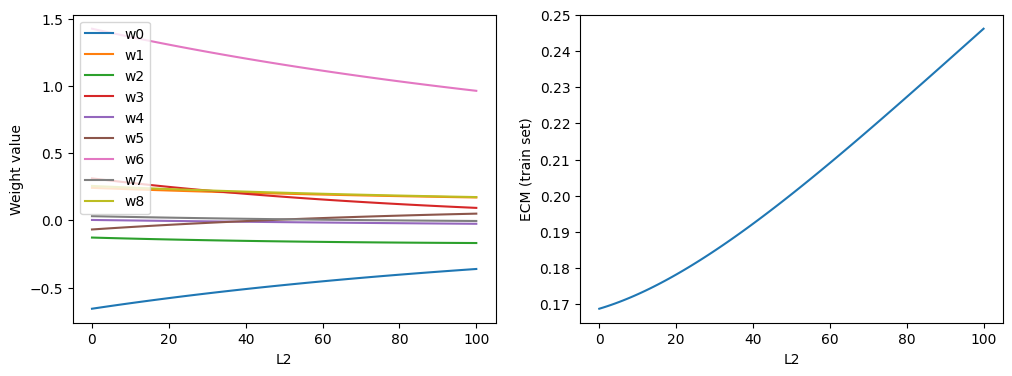

In [4]:
L2s : list[float] = np.linspace(0, 100, 100)
ECM2s : list[float] = []
coefsL2 : list[tuple[float, float, float]] = []
for l in L2s:
    lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=l)
    lin.fit_gradient_descent(step_size=0.000005, tolerance=0.5, max_number_of_steps=1000)
    coefsL2.append(lin.coef)
    # ECM2s.append(lin.error_cuadratico_medio())
    ECM2s.append(lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(np.array(coefsL2).shape[1]):
    plt.plot(L2s, np.array(coefsL2)[:, i], label=f'w{i}')
plt.xlabel('L2')
plt.ylabel('Weight value')
plt.legend()
plt.subplot(1, 2, 2)
L2s : list[float] = np.linspace(0, 100, 100)
plt.xlabel('L2')
plt.ylabel('ECM (train set)')
plt.plot(L2s, ECM2s)
plt.show()

5.3 )

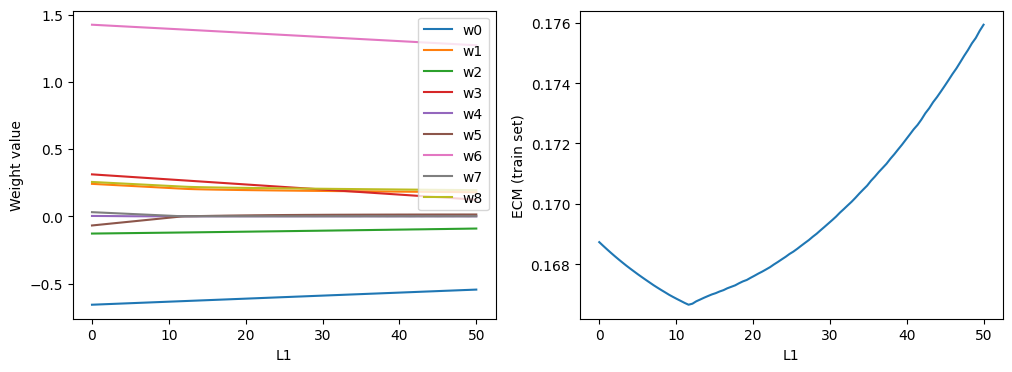

ECM alcanza un mínimo cuando L2 = 11.6162


In [ ]:
L1s : list[float] = np.linspace(0, 50, 100)
ECM1s : list[float] = []
coefsL1 : list[tuple[float, float, float]] = []
for l in L1s: 
    lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L1=l)
    lin.fit_gradient_descent(step_size=0.000005, tolerance=0.5, max_number_of_steps=1000)
    coefsL1.append(lin.coef)
    ECM1s.append(lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))
    # ECM1s.append(lin.error_cuadratico_medio())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(np.array(coefsL1).shape[1]):
    plt.plot(L1s, np.array(coefsL1)[:, i], label=f'w{i}')
plt.xlabel('L1')
plt.ylabel('Weight value')
plt.legend()
plt.subplot(1, 2, 2)
L1s : list[float] = np.linspace(0, 50, 100)
plt.xlabel('L1')
plt.ylabel('ECM (train set)')
plt.plot(L1s, ECM1s)
plt.show()
print(f"ECM alcanza un mínimo cuando L1 = {L1s[np.argmin(ECM1s)]:.4f}")

5.4 ) Utilizo el valor de L2 que minimice ECM. (Vimos en 5.2 que este valor es L2 = 45.4545)

In [6]:
lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=l)
lin.fit_pseudo_inverse()
print("PSEUDOINVERSA")
print("  ECM (train set)      : ", lin.error_cuadratico_medio())
print("  ECM (validation set) : ", lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))
lin : LinealReg = LinealReg(train_standarized.drop(columns='price').to_numpy(), train_standarized['price'].to_numpy(), L2=l)
lin.fit_gradient_descent(step_size=0.000005, tolerance=0.5, max_number_of_steps=1000)
print("GRADIENTE DESCENDENTE")
print("  ECM (train set)      : ", lin.error_cuadratico_medio())
print("  ECM (validation set) : ", lin.error_cuadratico_medio(validation_set_x=validation_standarized.drop(columns=['price']).to_numpy(), validation_set_y=validation_standarized['price'].to_numpy()))

PSEUDOINVERSA
  ECM (train set)      :  0.1896796717959808
  ECM (validation set) :  0.17040882953819986
GRADIENTE DESCENDENTE
  ECM (train set)      :  0.21732669939489943
  ECM (validation set) :  0.20037935279683347
